# Projecting conflict risk

In this notebook, we will show how CoPro uses a number of previously fitted classifiers and projects conflict risk forward in time. Eventually, these forward predictions based on multiple classifiers can be merged into a robust estimate of future conflict risk.

## Preparations

Start with loading the required packages.

In [1]:
from copro import utils, pipeline, evaluation, plots, machine_learning

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
from shutil import copyfile
import warnings
import glob
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.8
geopandas version: 0.9.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


To be able to also run this notebooks, some of the previously saved data needs to be loaded from a temporary location.

In [3]:
conflict_gdf = gpd.read_file(os.path.join('temp_files', 'conflicts.shp'))
selected_polygons_gdf = gpd.read_file(os.path.join('temp_files', 'polygons.shp'))

In [4]:
global_arr = np.load(os.path.join('temp_files', 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

## The configurations-file (cfg-file)

To be able to continue the simulation with the same settings as in the previous notebook, the cfg-file has to be read again and the model needs to be initialised subsequently. This is not needed if CoPro is run from command line. Please see the first notebook for additional information. 

In [5]:
settings_file = 'example_settings.cfg'

In [6]:
main_dict, root_dir = utils.initiate_setup(settings_file, verbose=False)


#### CoPro version 0.0.8 ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2021): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: reading model properties from example_settings.cfg
INFO: verbose mode on: False
INFO: saving output to main folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT


In [7]:
config_REF = main_dict['_REF'][0]
out_dir_REF = main_dict['_REF'][1] 

In addition to the config-object and output path for the reference period, `main_dict` also contains the equivalents for the projection run. In the cfg-file, an extra cfg-file can be provided per projection. 

In [8]:
config_REF.items('PROJ_files')

[('proj_nr_1', './example_settings_proj.cfg')]

In this example, the files is called `example_settings_proj.cfg` and the name of the projection is `proj_nr_1`.

In [9]:
config_PROJ = main_dict['proj_nr_1'][0]
print('the configuration of the projection run is {}'.format(config_PROJ))
out_dir_PROJ = main_dict['proj_nr_1'][1] 
print('the output directory of the projection run is {}'.format(out_dir_PROJ))

the configuration of the projection run is [<configparser.RawConfigParser object at 0x0000021E18A03508>]
the output directory of the projection run is C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\proj_nr_1


In the previous notebooks, conflict at the last year of the reference period as well as classifiers were stored temporarily to another folder than the output folder. Now let's copy these files back to the folders where the belong.

In [10]:
%%capture

for root, dirs, files in os.walk('temp_files'):
    
    # conflicts at last time step
    files = glob.glob(os.path.abspath('./temp_files/conflicts_in*'))
    for file in files:
        fname = file.rsplit('\\')[-1]
        print(fname)
        copyfile(os.path.join('temp_files', fname),
                 os.path.join(out_dir_REF, 'files', str(fname)))
        
    # classifiers
    files = glob.glob(os.path.abspath('./temp_files/clf*'))
    for file in files:
        fname = file.rsplit('\\')[-1]
        print(fname)
        copyfile(os.path.join('temp_files', fname),
                 os.path.join(out_dir_REF, 'clfs', str(fname)))

Similarly, we need to load the sample data (X) for the reference run as we need to fit the scaler with this data before we can make comparable and consistent projections.

In [11]:
config_REF.set('pre_calc', 'XY', str(os.path.join(out_dir_REF, 'XY.npy')))
X, Y = pipeline.create_XY(config_REF, out_dir_REF, root_dir, selected_polygons_gdf, conflict_gdf)

INFO: loading XY data from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\XY.npy


Lastly, we need to get the scaler for the samples matrix again. The pre-computed and already fitted classifiers are directly loaded from file (see above). The clf returned here will not be used.

In [12]:
scaler, clf = pipeline.prepare_ML(config_REF)

## Project!

With this all in place, we can now make projections. Under the hood, various steps are taken for each projectio run specified:

1. Load the corresponding ConfigParser-object;
2. Determine the projection period defined as the period between last year of reference run and projection year specified in cfg-file of projection run;
3. Make a separate projection per classifier (the number of classifiers, or model runs, is specified in the cfg-file):
    1. in the first year of the projection year, use conflict data from last year of reference run, i.e. still observed conflict data;
    2. in all following year, use the conflict data projected for the previous year with this specific classifier;
    3. all other variables are read from file for all years.
4. Per year, merge the conflict risk projected by all classifiers and derive a fractional conflict risk per polygon.

For detailed information, please see the documentatoin and code of `copro.pipeline.run_prediction()`. As this is one function doing all the work, it is not possible to split up the workflow in more detail here.

In [13]:
all_y_df = pipeline.run_prediction(scaler.fit(X[: , 2:]), main_dict, root_dir, selected_polygons_gdf)

INFO: loading config-object for projection run: proj_nr_1
INFO: the projection period is 2013 to 2015
INFO: making projection for year 2013
INFO: making projection for year 2014
INFO: making projection for year 2015


## Analysis of projection

All the previously used evaluation metrics are not applicable anymore, as there are no target values anymore. We can still look what the mean conflict probability is as computed by the model per polygon.

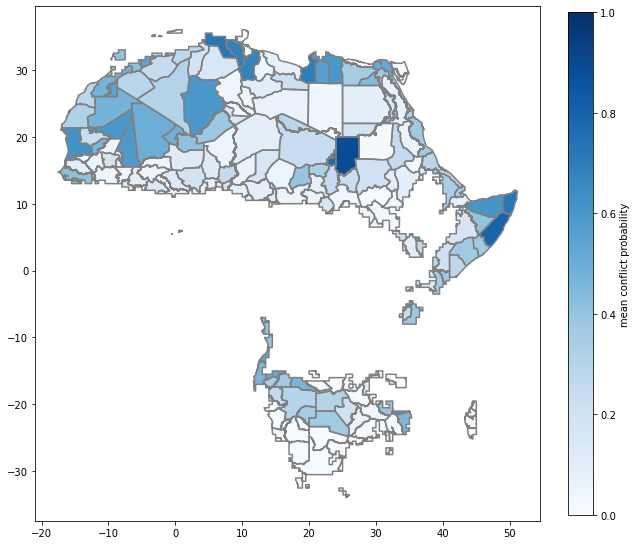

In [15]:
# link projection outcome to polygons via unique polygon-ID
df_hit, gdf_hit = evaluation.polygon_model_accuracy(all_y_df, global_df, make_proj=True)

# and plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_hit.plot(ax=ax, column='probability_of_conflict', legend=True, figsize=(20, 10), cmap='Blues', vmin=0, vmax=1,
         legend_kwds={'label': "mean conflict probability", 'orientation': "vertical", 'fraction': 0.045})
selected_polygons_gdf.boundary.plot(ax=ax, color='0.5');

## Projection output

The conflict projection per year is also stored in the output folder of the projection run as geoJSON files. These files can be used to post-process the data with the scripts provided with CoPro or to load them into bespoke scripts and functions written by the user.